# ImpDAR Autopicking Tutorial

# Introduction

This repository is for an autopicking method that is still in its very early stages. There has been a lot of work put into finding a way to automatically contour layers in ice and snow radar data, with some moderate success for picking the surface and bed in a radargram (see the References section below). However, there has been much less success in picking internal layers, and certainly not the tens to hundreds of layers that can exist in a single line at the same time. This is important because picking is a time-consuming process, and is often limited by how the human eye can identify contours. Additionally, this process of digitizing internal reflectors in ice and snow data is critical to being able to validate ice and snow properties within an icesheet or glacier at depth. If you want to learn more about validating picks and how that is implemented in ImpDAR, there is another tutorial [here](https://github.com/Jakidxav/ImpDAR_tutorials/tree/master/plot_power) in this repository that goes into more detail.

## Semi-automated Picking

Currently, ImpDAR's picking library uses a wavelet to pick the maximum (or minimum) return of a wave packet at a specific frequency, and then to identify the surrounding peaks with opposite polarity. Below is an animated example of how the picker currently works in ImpDAR using a line from Hercules Dome, Antarctica. The magenta lines are the top and bottom of the wave packet while the green is the center. For well-stratified layers like those found in many icesheets, the picker works well and you can pick several lines at different depths relatively quickly. However, doing this for tens of lines collected over a field season becomes a lengthy process. The ImpDAR picker also works for less well-defined stratigraphy like that found in mountain glaciers, although picking can become difficult in the top layers of snow and firn. 

<img src="./images/picking_example.gif" width="750" align="center">

## Fully-automated Picking
Instead, automating this process so that we can achieve an objectively picked set of contours that does not then need additional human validation is prudent.

Most of the previous algorithms have relied heavily on domain knowledge within radioglaciology, but one route that ImpDAR is exploring for an autopicker is taking an image processing approach. We can take advantage of [scikit-image](https://scikit-image.org/)'s find_contours() method that implements the Marching Squares algorithm, and can help us find contours in glaciers and ice sheets. The rest of this Notebook will look at an example line taken from the Northeast Greenland Ice Stream (NEGIS) that has been loaded into ImpDAR and already undergone some processing steps.

## Algorithm Outline

The general processing flow should be something like this:
- Find the contours for a certain value.
- Find the left- and right-most x values in a contour, and use them to find the unique x values that span each contour.
- Find the central points inside the contours (maximima for ridges, minima for troughs), and get rid of those points for which we have less than two or more than three y values for each unique x value along the contour.
- Check to make sure that our unique x and central value list have non-zero lengths, meaning that we were able to find values for that contour. Note: for some contours along the top of the profile, this method is sometimes unable to find central values and thus we should not include them.
- Then find the top and bottom of the wave packet so that we can calculate power for each pick (which is what I would consider what we have at this point).

The whole process should be more or less automatic, and seeks to imitate the method currently implemented in ImpDAR. It is recommended that the user look along a trace beforehand to pick the value in the `find_contours()` method. As a short example, this is what we are trying to achieve.

<table><tr>
<td> <p>Example traces</p><img src="./images/example_many.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Pick a threshold</p><img src="./images/example_threshold.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Isolate contours (orange)</p><img src="./images/example_contours.png" style="width: 300px; height: 300px;"/> </td>
</tr></table>

<table><tr>
<td> <p>Find max or min of wave packet (green)</p><img src="./images/example_ridge_points.png" style="width: 300px; height: 300px;"/> </td>
    
<td> <p>Find peaks of opposite polarity (magenta)</p><img src="./images/example_ridges_troughs.png" style="width: 300px; height: 300px;"/> </td>

<td> <p>Remove contours from wave packet</p><img src="./images/finished_wave_packet.png" style="width: 300px; height: 300px;"/> </td>
</tr></table>

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib import colors, colorbar
from matplotlib.animation import FuncAnimation
%matplotlib inline

from skimage import measure

from impdar.lib import load
from impdar.lib import plot
from impdar.lib import process
from autopicker_process import *
from autopicker_plot import *

## Loading Data

In [2]:
#file on disk
green_mat = './data/nline5.mat'

#load in data
dat = load.load('mat', green_mat)[0]

In [3]:
vars(dat)

{'chan': 1,
 'data': array([[ 1.6573445e+04,  1.6879803e+04,  1.6720752e+04, ...,
          2.2557945e+04,  2.2430016e+04,  2.2409408e+04],
        [ 1.6404561e+04,  1.6689334e+04,  1.6548559e+04, ...,
          2.2425178e+04,  2.2307602e+04,  2.2284225e+04],
        [ 1.6235407e+04,  1.6500377e+04,  1.6376154e+04, ...,
          2.2292615e+04,  2.2184711e+04,  2.2159469e+04],
        ...,
        [-1.3460696e+00, -9.0857440e-01, -8.5832715e-01, ...,
         -3.0521524e-01, -3.1189924e-01, -7.1386606e-01],
        [-1.4388833e+00, -9.6377879e-01, -7.8529817e-01, ...,
         -2.8597730e-01, -2.2767024e-01, -6.3531178e-01],
        [-1.5138711e+00, -1.0075097e+00, -7.0039809e-01, ...,
         -2.6328605e-01, -1.4156653e-01, -5.4718399e-01]], dtype=float32),
 'decday': array([nan, nan, nan, ..., nan, nan, nan]),
 'dt': 5e-09,
 'lat': array([75.747521  , 75.74747735, 75.74743412, ..., 75.5931702 ,
        75.59312396, 75.59307845]),
 'long': array([-36.31617382, -36.31593759, -36.31570

A normal move-out correction has not yet been applied to our data, so let's calculate that attribute here so that we can use it later for plotting.

In [4]:
dat.nmo_depth = dat.travel_time / 2.0 * 1.69e8 * 1.0e-6

Let's isolate a trace and visualize it with ImpDAR's `plot_traces()` method.

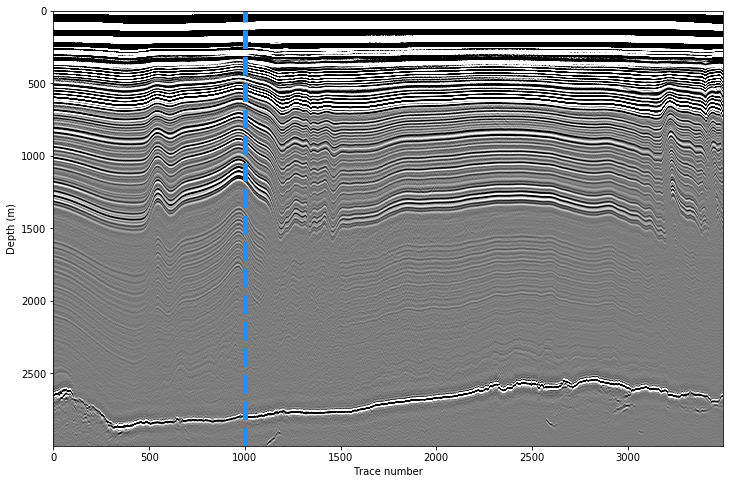

In [5]:
fig, ax = plot.plot_radargram(dat, ydat='depth')
ax.axvline(x=1000, color='dodgerblue', linewidth=5.0, linestyle='--')
plt.show()

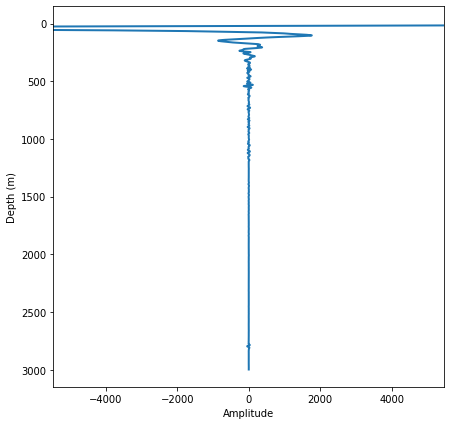

In [6]:
fig, ax = plt.subplots(figsize=(7, 7))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
plt.show()

Significant ringing at the surface (the large return at the top of the plot) is making it difficult to see what is happening deeper into the icesheet. Let's zoom in a bit. The signal is steadily decaying until about 2700m when we see a bigger return from the bedrock. To confirm this, look at the above radargram for trace 1000 and you will see this to be the case. It is important to also notice that the returned amplitude oscillates around 0, going from positive to negative, which we can use to our advantage to isolate contours at a specified returned amplitude.

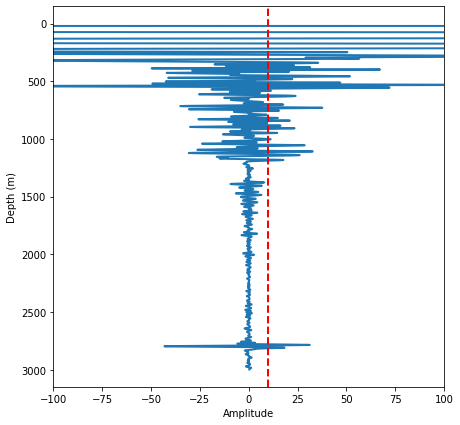

In [7]:
fig, ax = plt.subplots(figsize=(7, 7))
plot.plot_traces(dat, 1000, ydat='depth', linewidth=2.0, linestyle='solid', fig=fig, ax=ax)
ax.set_xlim(-100, 100)
ax.axvline(x=10, linestyle='--', color='r', linewidth=2.0)
plt.show()

## Isolating Contours

In the following examples, I will be using some helper functions that I wrote to process contours and find ridge/trough points in a wave packet. If you want to look more closely at how these methods work, you can find them in the `autopicker_methods.py` file accompanying this tutorial.

Now let's isolate all of the contours in a radargram. Ideally, we'd like to get as close to 0 as we could because our returned amplitude oscillates around 0. This would help us capture the most contours possible. However, this is **extremely** compute intensive. I have found good results extracting contours around some positive and negative amplitude close to 0, so that is what we will look at for the rest of this Notebook.

In [8]:
#get positive contours around some amplitude
#we could do the same for negative contours with `neg = find_contours(dat, -3)`
pos = find_contours(dat, 3)

Each contour is a set of (x, y) points surrounding the amplitude of interest in our radargram.

In [9]:
#each contour is a set of (x,y) pairs
print(np.shape(pos[0]))

(3843, 2)


The call to `find_contours()` returns a lot of contours. We can visualize them on top of our radargram below (keeping in mind that we actually have twice as many contours since we are not plotting the negative contours).

In [10]:
#colormap scaling values obtained from ImpDAR's plot function
min_ = -15
max_ = 15

#ytick list and labels
ytick_list = [0, 1184, 2367, 3551, 4734, 5917]
ytick_labels = [np.round(dat.nmo_depth[i], 2) for i in ytick_list]

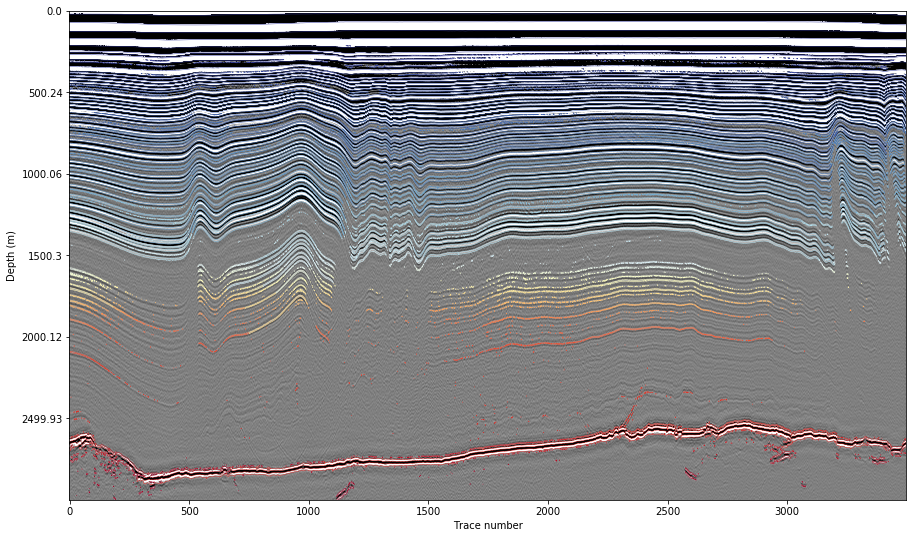

In [11]:
#plot all contours on radargram
plot_all_contours(dat, pos, min_, max_, ytick_list, ytick_labels)

These contours are closed loops around our amplitude of interest. What we actually want is to extract the top, middle, and bottom of our wave packet so that we can calculate power over the length of our automated picks.


Some things to point out might be that we can easily find longer contours around the bed and in most of top layers, as well as some middle layers. However, because of the threshold value that we are using for choosing contours we are missing some internal structure. This can be seen in the plot containing our trace of interest with the dashed red threshold line. Our threshold does not cross an amplitude oscillation between certain depths, and could be rectified by pushing the threshold closer to 0. 

Additionally, even with the processing steps we have already applied to this profile (cropping, interpolation, migration, etc.) there is inherent noise that needs to be taken into account. This could be due to the data collection process or the structure of the ice itself. When contours are broken or discontinuous, this means that a call to `find_contours()` will give us many small contours. We can filter these contours out by length for now.

In [12]:
#generate filtered set of contours
long_contours_pos = filter_contours(pos, 500)

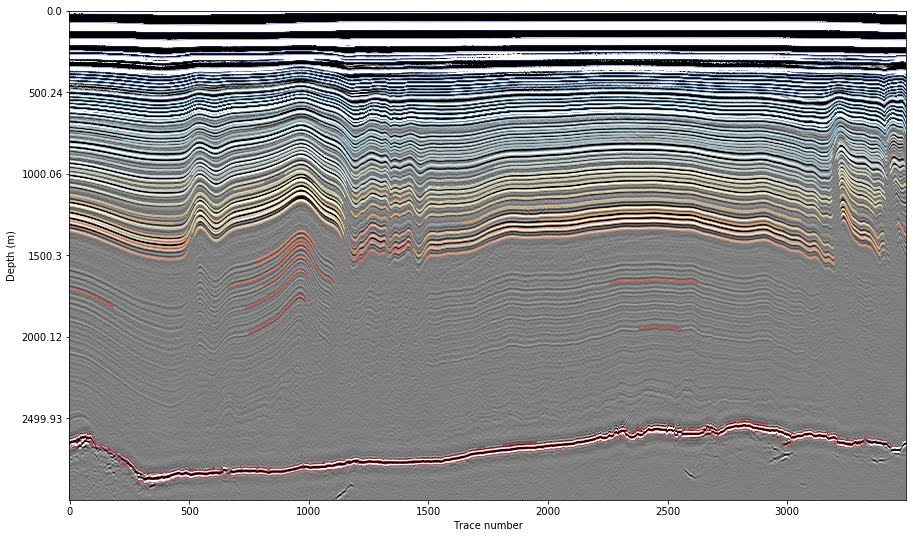

In [13]:
#let's examine the contours that are left
plot_all_contours(dat, long_contours_pos, min_, max_, ytick_list, ytick_labels)

In [14]:
#let's process all of the contours here
argx_list, uniquex_list, ridge_points_list, top_list, bottom_list = process_contours(dat, long_contours_pos)

A lot happened in that last method, so I will try to explain it here.

First, we found the minimum and maximum x-value along each contour. Then for every trace number in between those two points, we can find a unique set of y-values that exist at a particular x-value. Thus, if you are examining a contour at a given x-value, a vertical line would cross the closed contour loop only twice (once for each y-value). 

At each x-value, we can next look for some maximum positive or negative value. I use the terms *ridge* and *trough* a little bit loosely, but for positive contours we would look for a ridge in between the contour since it is enclosing some positive value of interest. From that ridge point, we then search for the first instance of where we detect a change in sign (in this case, going from positive to negative). This would signify leaving the ridge and entering a trough, and we do this search above and below every point along the contour to find the top and bottom of the wave packet. The process would be exactly the same for negative contours, except we would first search for a trough and then look for two ridges on either side of it.

So let's see how this works in practice.

In [15]:
#pick some contour from an internal layer at random, will be used to access contour/point lists
z = 159

#create new axis ticks and labels for zoomed in plot
ytick_list_contours = [4560, 4580, 4600, 4620, 4640, 4660, 4680]
ytick_labels_contours = [np.round(dat.nmo_depth[i], 2) for i in ytick_list_contours]

xlims = [2350, 2600]
ylims = [4680, 4550]

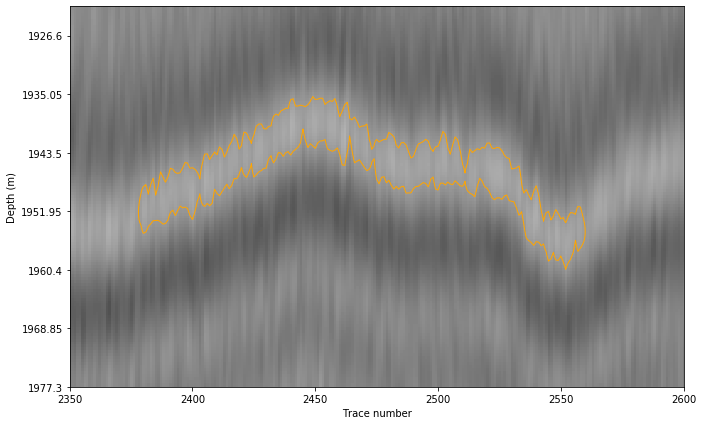

In [16]:
#plot zoomed-in view of contour
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z, min_, max_, xlims, ylims, ytick_list_contours, ytick_labels_contours, True, False, False)

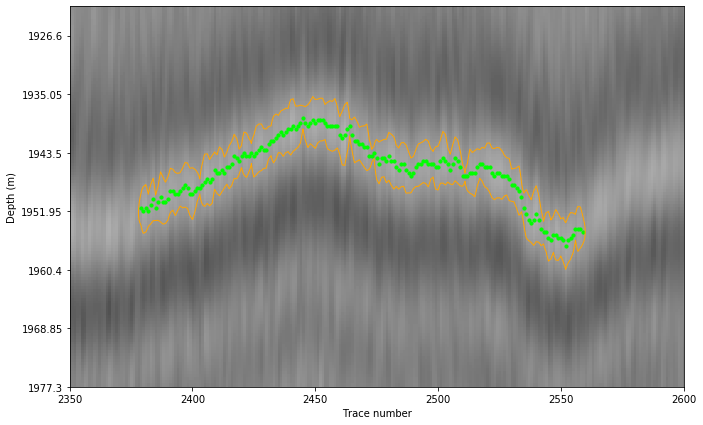

In [17]:
#plot ridge points
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z, min_, max_, xlims, ylims, ytick_list_contours, ytick_labels_contours, True, True, False)

The following animation shows how the algorithm find the ridge points, although it is a bit blurry due to video compression. The code used to produce the GIF is in the `autopicker_plot.py` helper method file.

<img src="./images/ridgeline.gif" width="900" align="center">

For each x-value within the contour, we can find the two y-values along the contour (represented by the vertical line). Then in between those values, there is a maximum (or minimum) value that represents a single ridge point. If we do this for every x-value in the contour, we can stitch together a whole ridge.

Next, we can find the trough points on either side of the ridge points.

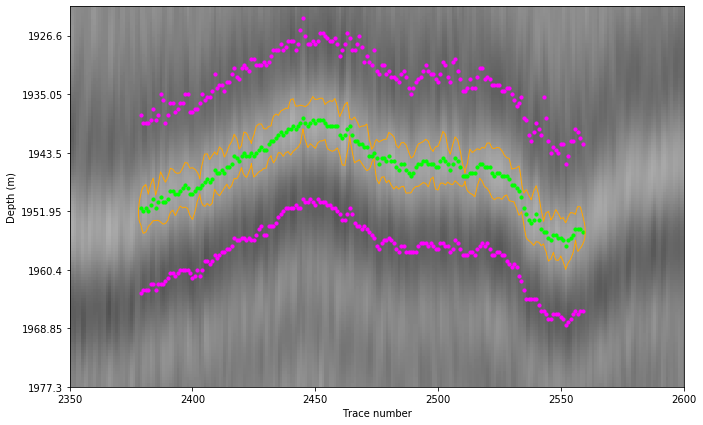

In [18]:
#plot top and bottom of wave packet
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z, min_, max_, xlims, ylims, ytick_list_contours, ytick_labels_contours, True, True, True)

And then if we drop the initial contour we have our wave packet.

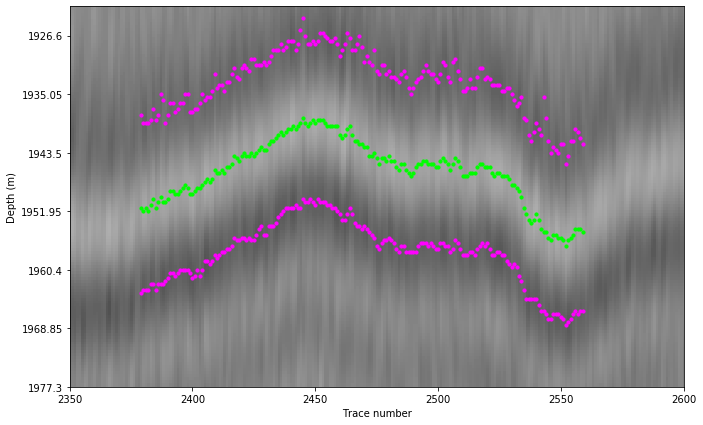

In [19]:
#plot complete wave packet
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z, min_, max_, xlims, ylims, ytick_list_contours, ytick_labels_contours, False, True, True)

This is what we wanted. We now have something that we can compute power across, meaning that if we can stitch together multiple wave packets extracted from contours then we can validate whether we have found a single layer in the profile.

This also works relatively well for contours at the bed.

In [20]:
#choose a contour on the bed
z2 = 165

xlims2 = [600, 2350]
ylims2 = [6800, 6000]

ytick_list_contours2 = [6000, 6100, 6200, 6300, 6500, 6600, 6700, 6800]
ytick_labels_contours2 = [np.round(dat.nmo_depth[i], 2) for i in ytick_list_contours2]

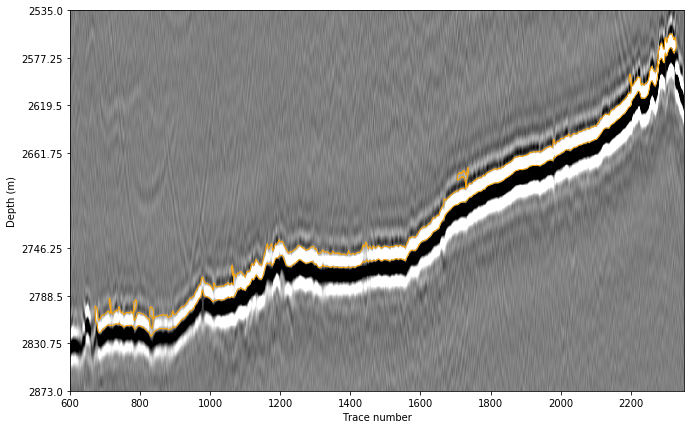

In [21]:
#plot contour
#this contour goes most of the way along the bed
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z2, min_, max_, xlims2, ylims2, ytick_list_contours2, ytick_labels_contours2, True, False, False)

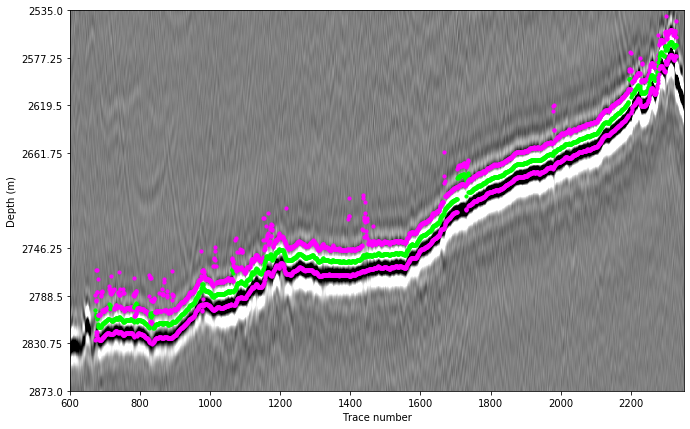

In [22]:
#plot wave packet
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z2, min_, max_, xlims2, ylims2, ytick_list_contours2, ytick_labels_contours2, False, True, True)

However, one problem with the current algorithm implementation is that contours are selected somewhat randomly by the Marching Squares algorithm, which sometimes leads to physically unrealistic contours.

In [23]:
#choose a problematic contour
z3 = 162

ytick_list_contours3 = [5950, 6000, 6050, 6100, 6150, 6200, 6250]
ytick_labels_contours3 = [np.round(dat.nmo_depth[i], 2) for i in ytick_list_contours3]

xlims3 = [2500, 2750]
ylims3 = [6250, 5950]

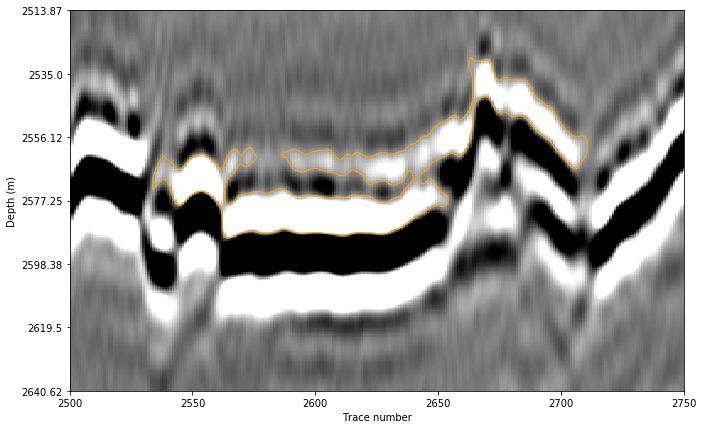

In [24]:
#plot contour
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z3, min_, max_, xlims3, ylims3, ytick_list_contours3, ytick_labels_contours3, True, False, False)

Which can lead to wave packets that are discontinuous and not following the line that we'd like.

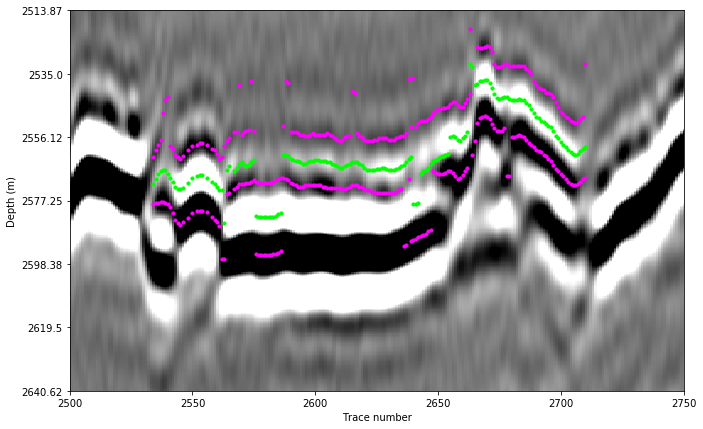

In [25]:
#plot wave packet
plot_wave_packet(dat, long_contours_pos, ridge_points_list, uniquex_list, top_list, bottom_list, z3, min_, max_, xlims3, ylims3, ytick_list_contours3, ytick_labels_contours3, False, True, True)

## Caveats
Here are some caveats to this method:
- For especially noisy profiles, this contouring method will not yield desirable results. This method is only as good as the processing steps that proceed it.
- That being said, this method works best for ice sheet data with planar, visibly continuous layers. It does not work as well for snow and firn data.
- Picks near the bed are often not classified well. However, this method is not currently meant to pick the bed, but only internal reflectors. There are already a plethora of methods for picking the surface and bed of a radargram, although they are not currently implemented with this autopicking method.
- The fully automatic picker will pick contours below the bed since we are using an image processing approach: the autopicker does not currently discern between what is and what isn't the bed-rock interface, it simply looks at "pixel" values. This would need to be corrected so that you don't compare ice and bedrock stratigraphy.

## Future Work

I think that the first thing that could be done to improve this algorithm is to go through and smooth contours. If you look at the problematic example above, one thing we could have done is examine each contour and make sure that individual trace numbers only have a set of two points along the contour's curve. That would force the algorithm to form smooth, closed loops that remove the odd blobs that come off the contour, giving us something more physically realistic. This would then help the algorithm to pick better ridge and trough pairs as a result of our contours becoming more continuous and streamlined.

Next, we need to think about how to connect the contours for a given layer in the ice. One suggestion in the literature is to create a coherence metric (Hale, 2009) that we can then compare the contours by. However, I found that for fairly smooth, flat layers, coherence is mostly the same for all contours making it hard to compare them directly. Another idea is to compare the power across a wave packet extracted from a contour with another. This sounds promising, but you would need to consider that large picks could vary drastically across their length, skewing their average, meaning that it wouldn't be straightforward for how to stich together picks of different lengths.

Lastly, you would need to consider how to compare picks that vary in position and depth. The Marching Squares algorithm picks contours somewhat randomly, so the contours are unsorted in their list data structure. That means that if I choose a contour at position `i`, the contour at `i+1` might be at a totally different position in the radargram. Thus, some metric for sorting the contours might help with being able to connect contours later on. One way to go about this would be to sort contours by starting x-position in the radargram. It is reasonable to believe that a layer in an ice sheet will not bend backwards on itself, so then you could compare only those contours that started to the right of it. How far above and below you searched for a matching contour is most likely another hyperparameter in your grid search, but because the bed can vary wildly in height from profile to profile, it is not straightforward how this process would be automated.

Still, I believe that taking an image-processing approach may prove useful for identifying and extracting internal reflectors from icesheet profiles in the future.

## References
If you would like to read more about the efforts to create an autopicker within the radioglaciological community, here are a list of references that we have found helpful:

- Hale, D.,v2009: Structure-oriented smoothing and semblance. CWP Report 635, 10 pp., http://inside.mines.edu/~dhale/papers/Hale09StructureOrientedSmoothingAndSemblance.pdf

- Stéfan van der Walt, Johannes L. Schönberger, Juan Nunez-Iglesias, François Boulogne, Joshua D. Warner, Neil Yager, Emmanuelle Gouillart, Tony Yu and the scikit-image contributors. scikit-image: Image processing in Python, PeerJ 2:e453 (2014)

- Sheriff, R. E., and L. P. Geldart, 1995: Exploration Seismology, Second Edition. Cambridge University Press, 592 pp.

- Lorensen, William and Harvey E. Cline. Marching Cubes: A High Resolution 3D Surface Construction Algorithm. Computer Graphics (SIGGRAPH 87 Proceedings) 21(4) July 1987, p. 163-170).

- Ferro, A., & Bruzzone, L. (2012). Automatic extraction and analysis of ice layering in radar sounder data. IEEE Transactions on Geoscience and Remote Sensing, 51(3), 1622-1634.

- Kamangir, H., Rahnemoonfar, M., Dobbs, D., Paden, J., & Fox, G. (2018, July). Deep hybrid wavelet network for ice boundary detection in radra imagery. In IGARSS 2018-2018 IEEE International Geoscience and Remote Sensing Symposium (pp. 3449-3452). IEEE.

- Crandall, D. J., Fox, G. C., & Paden, J. D. (2012, November). Layer-finding in radar echograms using probabilistic graphical models. In Proceedings of the 21st International Conference on Pattern Recognition (ICPR2012) (pp. 1530-1533). IEEE.

- Mitchell, J. E., Crandall, D. J., Fox, G. C., & Paden, J. D. (2013, July). A semi-automatic approach for estimating near surface internal layers from snow radar imagery. In 2013 IEEE International Geoscience and Remote Sensing Symposium-IGARSS (pp. 4110-4113). IEEE.

- Xu, M., Fan, C., Paden, J. D., Fox, G. C., & Crandall, D. J. (2018, March). Multi-task spatiotemporal neural networks for structured surface reconstruction. In 2018 IEEE Winter Conference on Applications of Computer Vision (WACV) (pp. 1273-1282). IEEE.